# 01. Importing Libraries and Datasets

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#Configure API key (I am not using this but for practice)

quandl.ApiConfig.api_key = 'Bz2YXL9kEojsgdb17xuf'

In [3]:
#This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
#defining path

path = r'C:\Users\Jonathan\Desktop\Amsterdam AirBnB'

In [5]:
#importing dataset

df = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'calendar.csv'), index_col = False)

# 02. Data Cleaning

In [6]:
df.head()

,listing_id,date,available,price
0,2818,2019-12-05,f,NaN
1,73208,2019-08-30,f,NaN
2,73208,2019-08-29,f,NaN
3,73208,2019-08-28,f,NaN
4,73208,2019-08-27,f,NaN


In [7]:
#Remove $ sign on the price column and convert to numeric value

df['price'] = df['price'].apply(lambda x: str(x).replace('$',''))
df['price'] = pd.to_numeric(df['price'], errors = 'coerce')
df_cal = df.groupby('date')[["price"]].sum()
df_cal['mean'] = df.groupby('date')[["price"]].mean()
df_cal.columns = ['Total','Avg']
df_cal.head()

,Total,Avg
date,,
2018-12-06,194793.0,164.799492
2018-12-07,283038.0,200.736170
2018-12-08,347881.0,203.916178
2018-12-09,486529.0,170.234080
2018-12-10,527062.0,160.006679


In [8]:
df_cal = df_cal.drop(['Total'], axis =1)

In [9]:
df_cal.shape

(366, 1)

In [10]:
df_cal.columns

Index(['Avg'], dtype='object')

In [11]:
#Check for duplicates

dups = df_cal.duplicated()
dups.sum()

0

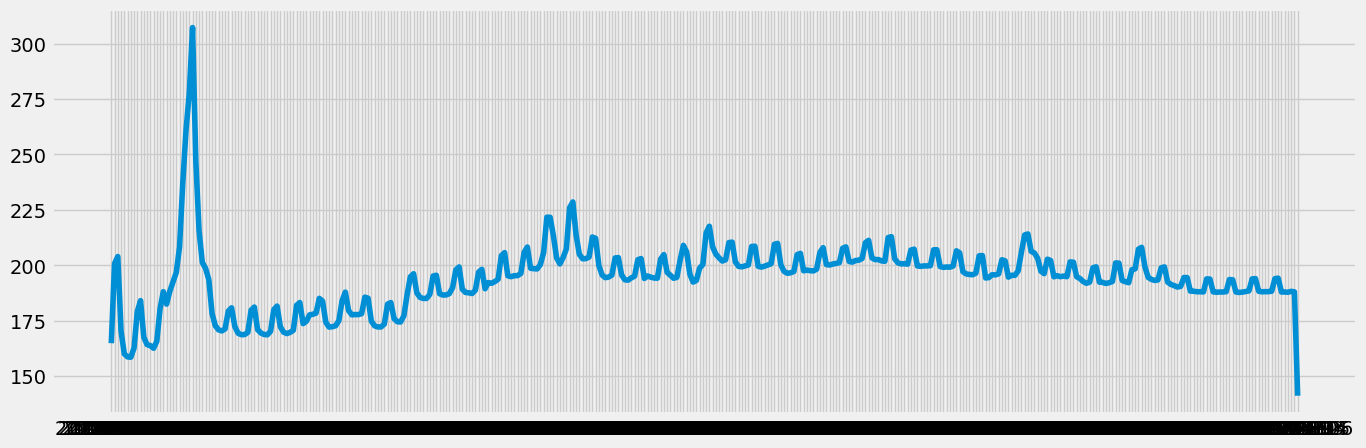

In [12]:
#Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(df_cal)

In [14]:
#Reset index so that you can use the "Date" column as a filter

df_cal_2 = df_cal.reset_index()

In [15]:
#Set the "Date" column as the index

from datetime import datetime

df_cal_2['datetime'] = pd.to_datetime(df_cal_2['date'])
df_cal_2 = df_cal_2.set_index('datetime')
df_cal_2.drop(['date'], axis=1, inplace=True) 
df_cal_2.head()

,Avg
datetime,
2018-12-06,164.799492
2018-12-07,200.736170
2018-12-08,203.916178
2018-12-09,170.234080
2018-12-10,160.006679


# 03. Time-Series Analysis: Decomposition

In [17]:
#Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_cal_2, model='additive')

In [18]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

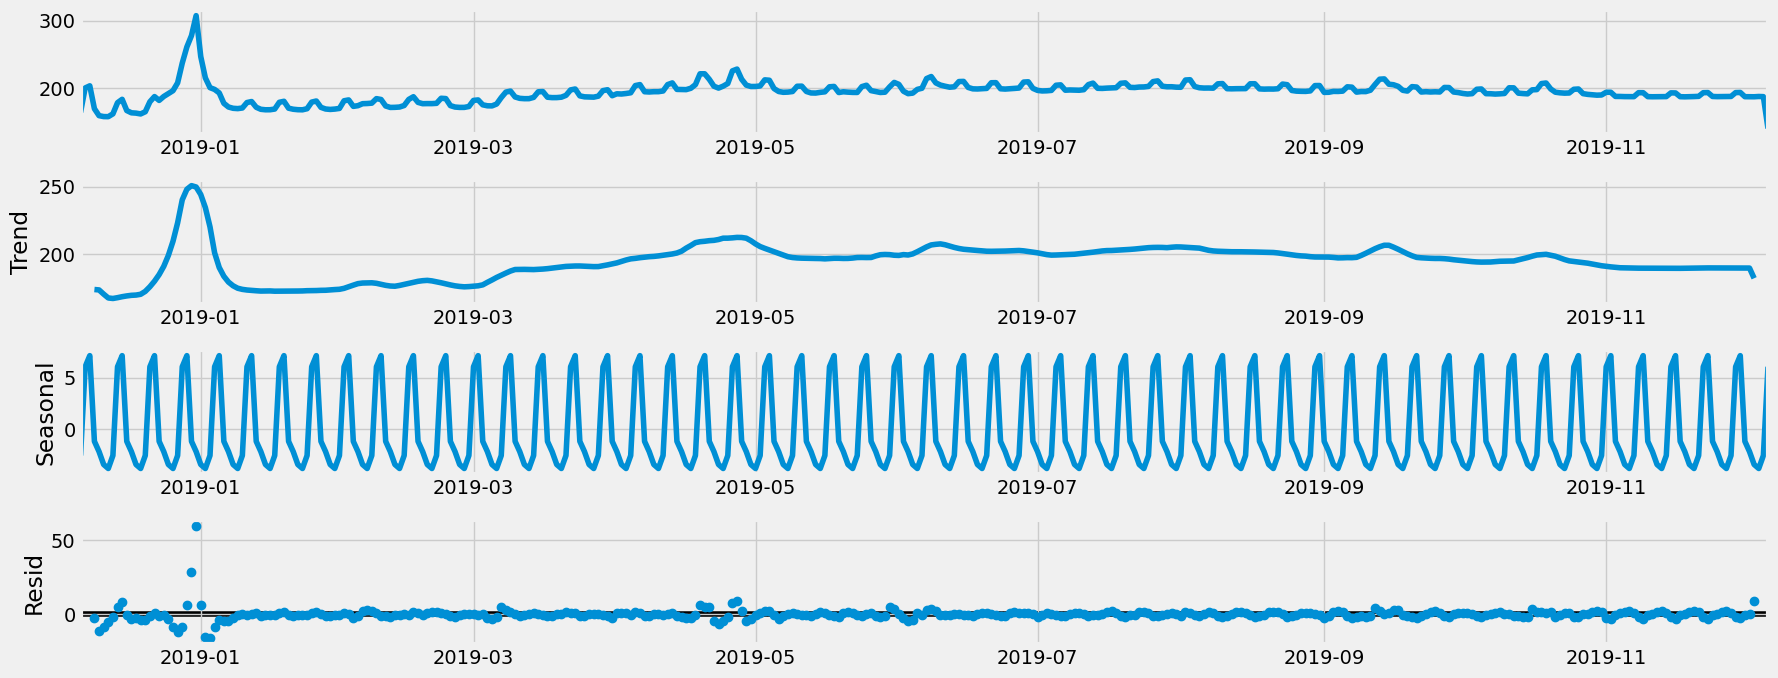

In [19]:
#Plot the separate components

decomposition.plot()
plt.show()

Looking at the decomposition chart we can see that the Level Data and the Trend Data look very similar although the the Trend Data is smoother. The Seasonality Data looks to be there in this dataset when looking at average price of rental properties throughout the year because it is not a flat line. The Residual Data also seems normal because there is not much unexplained noise in the data.  

# 04. Testing for Stationarity

In [20]:
#The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
#an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(df_cal_2['Avg'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.147054
p-value                          0.023261
Number of Lags Used             15.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


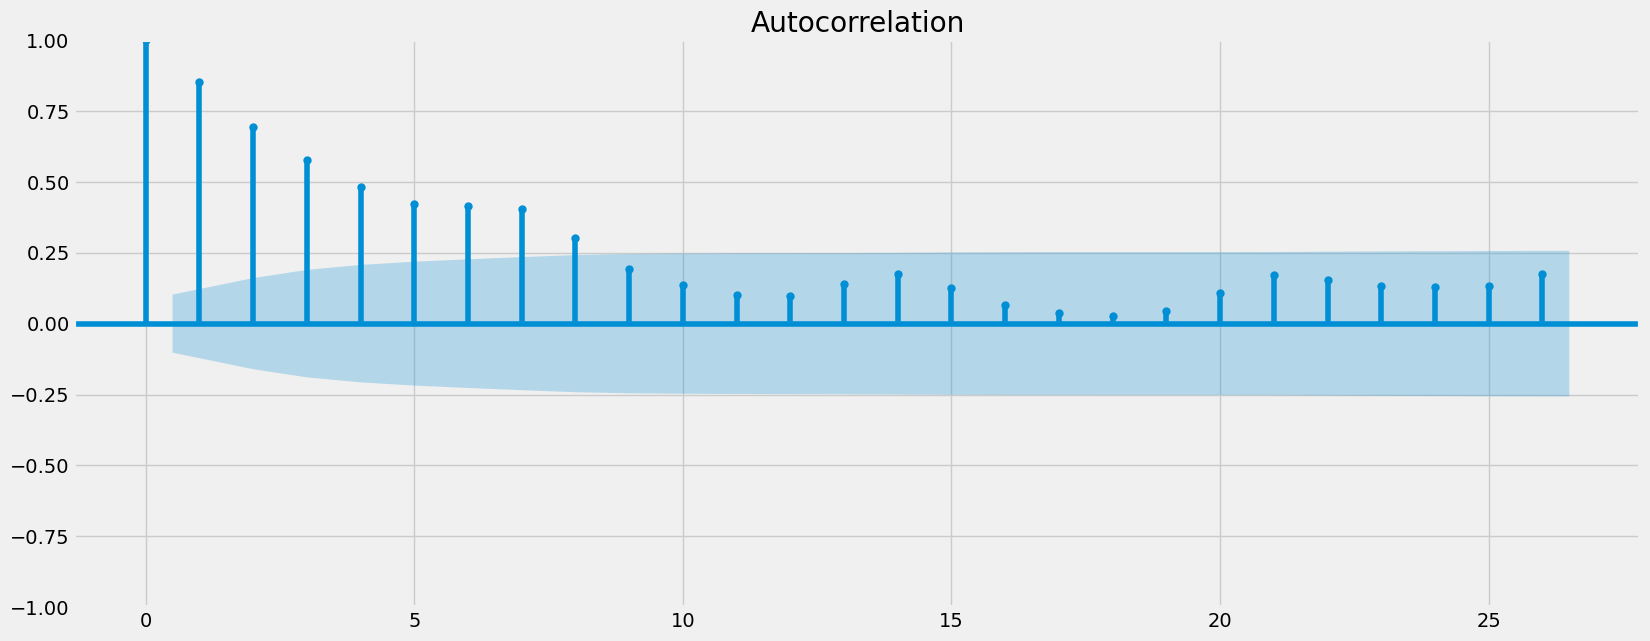

In [21]:
#Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_cal_2)
plt.show()

The Dickey-Fuller Stationarity test results seem to indicate that this dataset is stationary because the test statistic is smaller than both the 5% and 10% Critical Values. The p-value is less than 0.05 so that means it is a significant p-value. Thus the null hypothesis is disproved. 